In [182]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import GridSearchCV

prng = np.random.RandomState(20250310)

%precision 3
pd.set_option('display.precision', 3)

# Illustrating bias-variance trade-off: Univariate vs multivariate model

## Our problem

Let"s start with a simple linear model:

$$
Y = f(X) + \varepsilon = \beta_1 X_1 + \beta_2 X_2 + \varepsilon
$$

The true model is:

$$
f(X) = X_1 + X_2
$$

In [183]:
def trueModel(x1, x2):
    y = x1 + x2
    return y

def generateData(prng, sample_size):
    features = [prng.uniform(0, 1, size=sample_size) for _ in range(3)]
    y_true = trueModel(features[0], features[1])
    y = y_true + prng.normal(0, 2, size=sample_size) # sigma(epsilon) = 2
 
    feature_df = pd.DataFrame({
        'x1': features[0],
        'x2': features[1]
    })

    return feature_df, y


In [184]:
# Evaluate the model's performance at a single point: X=0.5
test_data = pd.DataFrame({'x1': [0], 'x2': [0]})
trueModel(test_data['x1'], test_data['x2'])[0]

np.int64(0)

## Estimate two models: Linear Regression and Lasso

In [185]:
sample_size = 20

X, y = generateData(prng, sample_size)

lm = LinearRegression()
lasso = Lasso(random_state=prng)

lm.fit(X, y)
lasso.fit(X, y)

pred_lm = lm.predict(test_data)
pred_lasso = lasso.predict(test_data)

print("Linear model prediction: ", pred_lm)
print("Lasso prediction: ", pred_lasso)

Linear model prediction:  [0.673]
Lasso prediction:  [1.288]


## Monte Carlo simulation

In [186]:
# Monte Carlo simulation

n_iterations = 1000
alphas_to_try = np.linspace(0.01, 0.5, num=20)

lm_predictions = np.empty(n_iterations)
lasso_predictions = np.empty((n_iterations, len(alphas_to_try)))
lasso_n_coeffs = np.empty((n_iterations, len(alphas_to_try)))

# Perform the Monte Carlo simulation
for i in range(n_iterations):

    X, y = generateData(prng, sample_size)

    lm_predictions[i] = LinearRegression().fit(X, y).predict(test_data)[0]

    for ida, a in enumerate(alphas_to_try):
        lasso_model = Lasso(alpha=a, random_state=prng)
        lasso_model = lasso_model.fit(X, y)
        lasso_predictions[i, ida] = lasso_model.predict(test_data)[0]
        lasso_n_coeffs[i, ida] = np.count_nonzero(lasso_model.coef_)

Linear Regression could be interpreted as a special case of Lasso with alpha = 0. Let's concatenate the predictions of the two models. (*Note that `lm_predictions` is a 1D array so first we need to reshape it to a 2D array with `reshape(-1, 1)`.*)

In [187]:
predictions = np.concatenate([lm_predictions.reshape(-1, 1), lasso_predictions], axis=1)
predictions.shape

(1000, 21)

In [188]:
alphas = np.concatenate([[0], alphas_to_try])
biases = np.mean(predictions - trueModel(test_data['x1'], test_data['x2'])[0], axis=0)
variances = np.var(predictions, axis=0)
mses = np.mean(np.square(predictions - trueModel(test_data['x1'], test_data['x2'])[0]), axis=0)

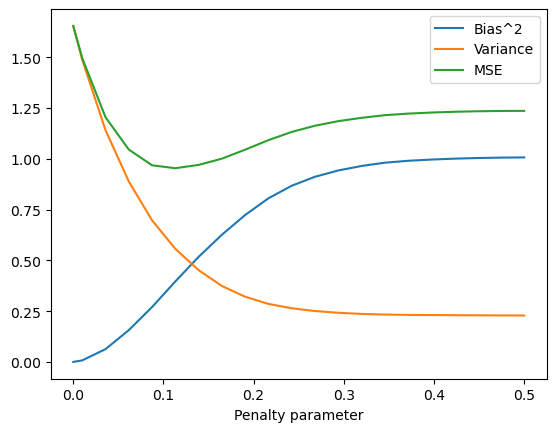

In [189]:
plt.plot(alphas, biases**2, label='Bias^2')
plt.plot(alphas, variances, label='Variance')
plt.plot(alphas, mses, label='MSE')
plt.xlabel('Penalty parameter')
plt.legend()
plt.show()

Penalized regression performs better than the true (unpenalized) model!

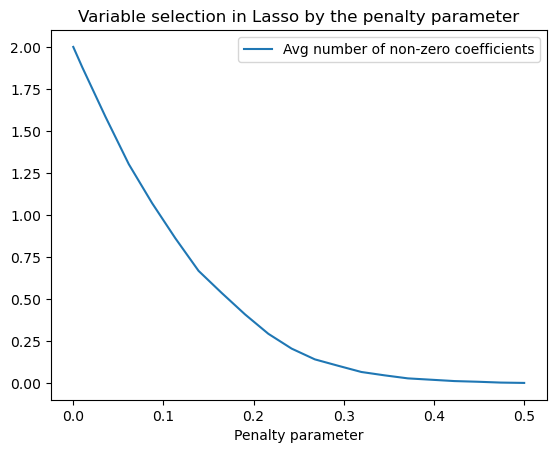

In [190]:
avg_num_coeffs = np.concatenate([[2], np.mean(lasso_n_coeffs, axis=0)])
plt.plot(alphas, avg_num_coeffs, label='Avg number of non-zero coefficients')
plt.xlabel('Penalty parameter')
plt.title('Variable selection in Lasso by the penalty parameter')
plt.legend()
plt.show()

## Finding the best penalty parameter with cross-validation (hyperparameter tuning)

In [191]:
lasso_cv = GridSearchCV(Lasso(random_state=prng), {'alpha': alphas_to_try}, cv=10, scoring='neg_mean_squared_error')
lasso_cv.fit(X, y)


GridSearchCV(cv=10,
             estimator=Lasso(random_state=RandomState(MT19937) at 0x308432440),
             param_grid={'alpha': array([0.01 , 0.036, 0.062, 0.087, 0.113, 0.139, 0.165, 0.191, 0.216,
       0.242, 0.268, 0.294, 0.319, 0.345, 0.371, 0.397, 0.423, 0.448,
       0.474, 0.5  ])},
             scoring='neg_mean_squared_error')

In [192]:
lasso_cv.best_params_

{'alpha': 0.242}

In [193]:
lasso_cv.predict(X)

array([1.145, 1.145, 1.145, 1.145, 1.145, 1.145, 1.145, 1.145, 1.145,
       1.145, 1.145, 1.145, 1.145, 1.145, 1.145, 1.145, 1.145, 1.145,
       1.145, 1.145])

In [195]:
print(f"Coefficients of the best model: beta_1={lasso_cv.best_estimator_.coef_[0]}, beta_2={lasso_cv.best_estimator_.coef_[1]}")
print(f"Intercept of the best model: {lasso_cv.best_estimator_.intercept_:.3f}")


Coefficients of the best model: beta_1=0.0, beta_2=0.0
Intercept of the best model: 1.145


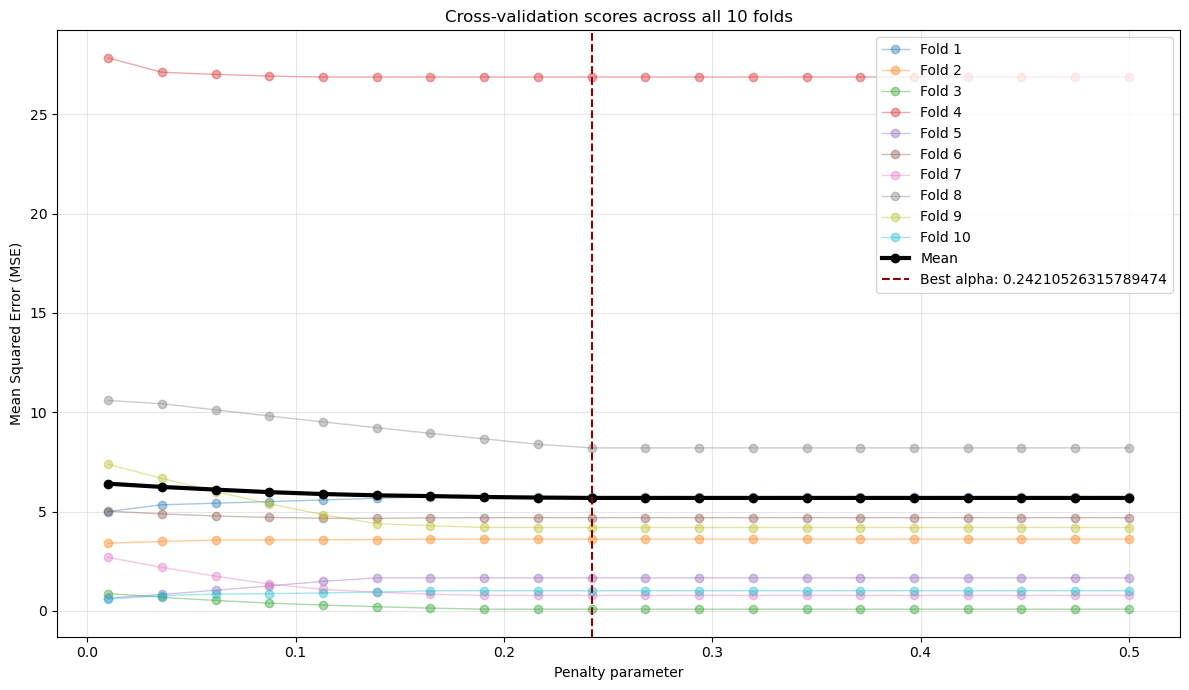

In [172]:
# Extract alpha values and scores for all 10 folds
alphas = lasso_cv.cv_results_['param_alpha'].data
mean_scores = -lasso_cv.cv_results_['mean_test_score']

plt.figure(figsize=(12, 7))

# Plot individual fold scores
for i in range(10):  # For all 10 folds
    fold_key = f'split{i}_test_score'
    fold_scores = -lasso_cv.cv_results_[fold_key]  # Negate to get MSE
    plt.plot(alphas, fold_scores, 'o-', alpha=0.4, linewidth=1, label=f'Fold {i+1}')

# Plot the mean score with heavier line
plt.plot(alphas, mean_scores, 'o-', linewidth=3, color='black', label='Mean')

# Mark the best alpha
best_alpha = lasso_cv.best_params_['alpha']
plt.axvline(x=best_alpha, color='darkred', linestyle='--', label=f'Best alpha: {best_alpha}')

plt.xlabel("Penalty parameter")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Cross-validation scores across all 10 folds")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Here we can only cook from the given data (n=20). In the previous example, we repeated the experiment 1000 times, allowing us to measure the average performance of the models across many possible datasets (so we basically cooked from 1000x20 data points). In contrast, cross-validation works with only the single available dataset, which better reflects the real life situation where we must estimate performance using only the data at hand.